# VAC Classe


In [12]:
import os
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Conv1D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Conv1DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import tensorflow as tf

from tensorflow.keras.losses import BinaryCrossentropy

tf.compat.v1.disable_eager_execution()

class VAE:
    """
    VAE represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape # [1024 1]
        self.conv_filters = conv_filters 
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim
        self.reconstruction_loss_weight = 1000

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build()

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()

    def compile(self, learning_rate=0.0001):
        print('In compile.')
        optimizer = Adam(learning_rate=learning_rate)
        print('Optimizer set.')
        self.model.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss)
        print('End of compile')

    def train(self, x_train, batch_size, num_epochs):
        self.model.fit(x_train,
                       x_train,
                       batch_size = batch_size,
                       epochs=num_epochs,
                       shuffle=True)

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _calculate_combined_loss(self, y_target, y_predicted):
        reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
        kl_loss = self._calculate_kl_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
                                                         + kl_loss
        return combined_loss

    def _calculate_reconstruction_loss(self, y_target, y_predicted):
        error = y_target - y_predicted
        reconstruction_loss = K.mean(K.square(error), axis=[1,2])
        return reconstruction_loss

    def _calculate_kl_loss(self, y_target, y_predicted):
        kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) -
                               K.exp(self.log_variance), axis=1)
        return kl_loss

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    def _build(self):
        self._build_encoder()
        print('1-Encoder Built.')
        self._build_decoder()
        print('1-Decoder Built.')
        self._build_autoencoder()

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        """Add conv transpose blocks."""
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv1DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv1DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        output_layer= x
        return output_layer

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        """Create all convolutional blocks in encoder."""
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """Add a convolutional block to a graph of layers, consisting of
        conv 2d + ReLU + batch normalization.
        """
        layer_number = layer_index + 1
        conv_layer = Conv1D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck with Guassian sampling (Dense
        layer).
        """
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        self.mu = Dense(self.latent_space_dim, name="mu")(x)
        self.log_variance = Dense(self.latent_space_dim,
                                  name="log_variance")(x)

        def sample_point_from_normal_distribution(args):
            mu, log_variance = args
            epsilon = K.random_normal(shape=K.shape(self.mu), mean=0.,
                                      stddev=1.)
            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            return sampled_point

        x = Lambda(sample_point_from_normal_distribution,
                   name="encoder_output")([self.mu, self.log_variance])
        return x

# Import Data

In [14]:
import h5py 

with h5py.File('/content/drive/MyDrive/KalmanNetProject/meas000.data','r') as hdf:
    ls = list(hdf.keys())
    print(ls)
    data = hdf.get('fetalSignal')
    data = np.array(data)
    data = data.reshape(6,810000)
    print(data.shape)
    peaks = hdf.get('fRpeaks')
    peaks = np.array(peaks)
    peaks = peaks.reshape(1,1631)
    print(peaks.shape)

['fRpeaks', 'fetalSignal']
(6, 810000)
(1, 1631)


In [38]:
input_length = 1024
number_inputs = 791

ecg = data[:,0:input_length*number_inputs]
ecg_train = ecg[0:5,:]
print('Ecg train shape')
print(ecg_train.shape)
ecg_train = ecg_train.reshape(5*number_inputs,input_length,1)
print(ecg_train.shape)

ecg_test = ecg[5:6,:]
print('Ecg test shape')
print(ecg_test.shape)
ecg_test = ecg_test.reshape(1*number_inputs,input_length)
print(ecg_test.shape)

Ecg train shape
(5, 809984)
(3955, 1024, 1)
Ecg test shape
(1, 809984)
(791, 1024)


In [40]:
ecg_train = np.nan_to_num(ecg_train)
print(ecg_train.shape)
ecg_test = np.nan_to_num(ecg_test)
print(ecg_test.shape)

(3955, 1024, 1)
(791, 1024)


In [42]:
np.count_nonzero(np.isnan(ecg_train))

0

# Main


In [44]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
EPOCHS = 10

def train(x_train, learning_rate, batch_size, epochs):
    autoencoder = VAE(
        input_shape=(1024, 1),
        conv_filters=(40, 20, 20, 20, 40),
        conv_kernels=(16, 16, 16, 16, 16),
        conv_strides=(2, 2, 2, 2, 2),
        latent_space_dim= 100
    )
    autoencoder.summary()
    print('Before Compile')
    autoencoder.compile(learning_rate)
    print('Compiled')
    autoencoder.train(x_train, batch_size, epochs)
    return autoencoder

autoencoder = train(ecg_train, LEARNING_RATE, BATCH_SIZE, EPOCHS)
autoencoder.save("model")

1-Encoder Built.
1-Decoder Built.
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 1024, 1)]    0           []                               
                                                                                                  
 encoder_conv_layer_1 (Conv1D)  (None, 512, 40)      680         ['encoder_input[0][0]']          
                                                                                                  
 encoder_relu_1 (ReLU)          (None, 512, 40)      0           ['encoder_conv_layer_1[0][0]']   
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 512, 40)     160         ['encoder_relu_1[0][0]']         
 on)                                                      

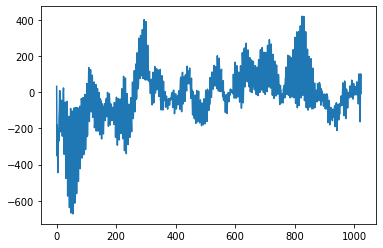

In [45]:
import matplotlib.pyplot as plt
plt.plot(ecg_train[0,:].reshape(1024,1))

In [46]:
reconstructed = autoencoder.reconstruct(ecg_train[0:1,:])
reconstructed[0].shape

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(1, 1024, 1)

In [47]:
reconstructed = np.asarray(reconstructed[0])
reconstructed.shape

(1, 1024, 1)

In [48]:
reconstructed = reconstructed.reshape(1024,1)

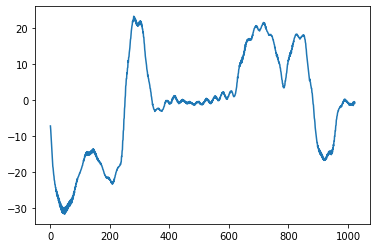

In [49]:
plt.plot(reconstructed)

In [70]:
import tensorflow as tf

In [73]:
a = tf.ones((1,4,1))

In [74]:
print(a)

Tensor("ones_5:0", shape=(1, 4, 1), dtype=float32)


In [18]:
# Compute some values using a Tensor
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)
print(e)

Tensor("MatMul_2:0", shape=(2, 2), dtype=float32)


In [77]:
a = K.mean(a, axis = [1])

In [78]:
a = tf.reshape(a, (1,))

In [79]:
a

<tf.Tensor 'Reshape_9:0' shape=(1,) dtype=float32>

In [19]:
autoencoder.loss

AttributeError: ignored

In [11]:
reconstructed

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [36]:

a = np.array([np.nan,1,2,3,4,np.nan])

In [37]:
np.count_nonzero(~np.isnan(a))

4